In [112]:
import os 
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import skimage
from skimage import io
from pathlib import Path
import re
from skimage import exposure
import h5py
import cv2 
from skimage.util import img_as_ubyte, invert
from skimage import exposure
from skimage.transform import rescale


In [113]:
p_dir = (Path().cwd().parents[0]).absolute()

In [114]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import transform 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
experiment = 'Tonsil'
core = 'DonorE'

# import IMC data

In [116]:
from skimage.transform import rotate

h5_data_dir = p_dir / "data" / "h5"

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale


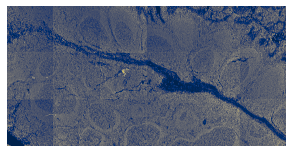

In [117]:
imgs, markers = get_imgs(f"{experiment} {core}", "IMC")
# subset = ["HistoneH3", 'SMA', 'COL1', 'DNA1']
# subset = ['COL1', 'DNA1', 'DNA2', 'Ki67', 'CD21', 'Vimentin']
subset = ['DNA1', 'DNA2']

img_dapi = np.max(contrast_stretching(imgs[[markers.index(marker) for marker in subset]]), axis=0)
img_dapi = contrast_stretching(img_dapi)

rotation_imc = 90
img_h3 = rotate(img_dapi, rotation_imc, resize=True)

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img_h3, cmap='cividis')
ax.axis('off')
plt.show()

In [118]:
# import napari

# viewer = napari.view_image(img_h3)
# viewer.add_image(img)

# Read H&E image 

In [119]:
match_info_dir = p_dir / 'data' / 'registration'

In [120]:
info = my_utils.load_pkl(match_info_dir / f'{core}_HE_IMC.pickle')
he_resolution =  0.37744 # um/pixel

HE_path = p_dir / 'data' / 'HE' 
img_he_path = HE_path / f'{core}.tif'

img_he_rgb = io.imread(img_he_path, as_gray=False)
img_he_rgb_rescale = rescale(img_he_rgb, he_resolution, multichannel=True)

rotation = info['rotation'] + rotation_imc
bbox = info['bbox']
bbox_r = info['bbox_r']

y, h_region, x, w_region = np.array(bbox) + np.array([-20, 20, -20, 20])
img = rotate(img_he_rgb_rescale[y:y+h_region, x:x+w_region], rotation)
y, h_region, x, w_region = np.array(bbox_r)
img = img[y:y+h_region, x:x+w_region,:]


C:\Users\thu71\AppData\Local\Temp/ipykernel_22048/3204894650.py:8: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_he_rgb_rescale = rescale(img_he_rgb, he_resolution, multichannel=True)


In [121]:
# img1 = img

# info = my_utils.load_pkl(match_info_dir / f'{core}_HE_IMC_2.pickle')
# he_resolution = 0.37744 # um/pixel

# HE_path = p_dir / 'data' / 'HE' 
# img_he_path = HE_path / f'{core}.tif'

# img_he_rgb = io.imread(img_he_path, as_gray=False)
# img_he_rgb_rescale = rescale(img_he_rgb, he_resolution, multichannel=True)

# rotation = info['rotation'] + rotation_imc
# bbox = info['bbox']
# bbox_r = info['bbox_r']

# y, h_region, x, w_region = np.array(bbox) + np.array([-20, 20, -20, 20])
# img = rotate(img_he_rgb_rescale[y:y+h_region, x:x+w_region], rotation)
# y, h_region, x, w_region = np.array(bbox_r)
# img2 = img[y:y+h_region, x:x+w_region,:]

# img = np.zeros((img_h3.shape[0], img_h3.shape[1], 3), dtype=img1.dtype)
# img[:2000,...] = img1
# img[-2000:,...] = img2

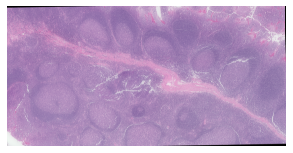

In [129]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(img)
ax.axis('off')
plt.show()

In [141]:
import napari

viewer = napari.view_image(img_h3)
viewer.add_image(img)

<Image layer 'img' at 0x18ae6ad94f0>

# Crop to region

In [137]:
def crop_img(img, info, rotation_imc):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"] - rotation_imc
    rotation_small = info["rotation_adjust"]
    border = info["border"]

    img = rotate(img, rotation, resize=True)
    img = cv2.copyMakeBorder(
        img, border, border, border, border, cv2.BORDER_CONSTANT, None, value=0
    )
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]
        img = rotate(img, rotation_small, resize=True)
        
    img = img[y : y + h_region, x : x + w_region,:]
    # img = contrast_stretching(img)
    # img = img_as_ubyte(img)
    return img

In [138]:
match_info_dir = p_dir / 'data' / 'match'

In [139]:
datasets = [f'{core}_{i}' for i in range(1,7)]
imgs_cropped = []
for i, dataset in enumerate(datasets):
    print(dataset)
    try:
        info_roi = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        print('Info not found')
        continue
    img_cropped = crop_img(img, info_roi, rotation_imc)
    imgs_cropped.append(img_cropped)


DonorE_1
DonorE_2
DonorE_3
DonorE_4
DonorE_5
DonorE_6


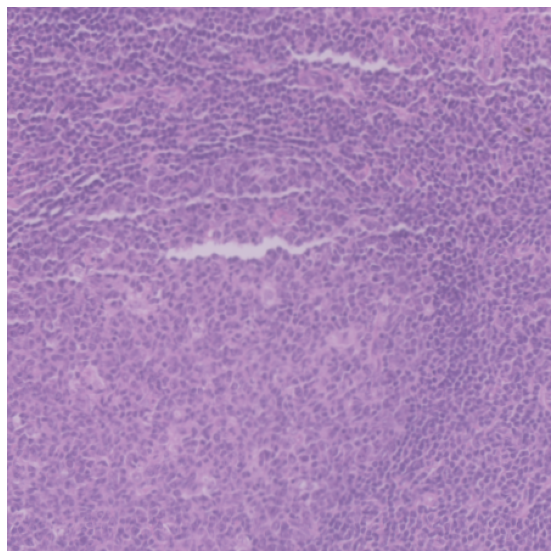

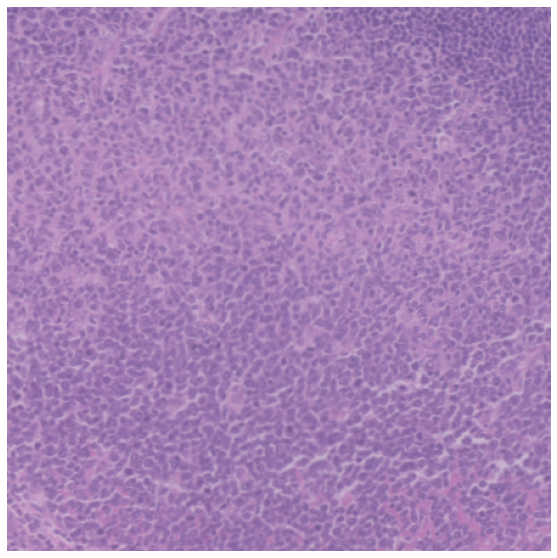

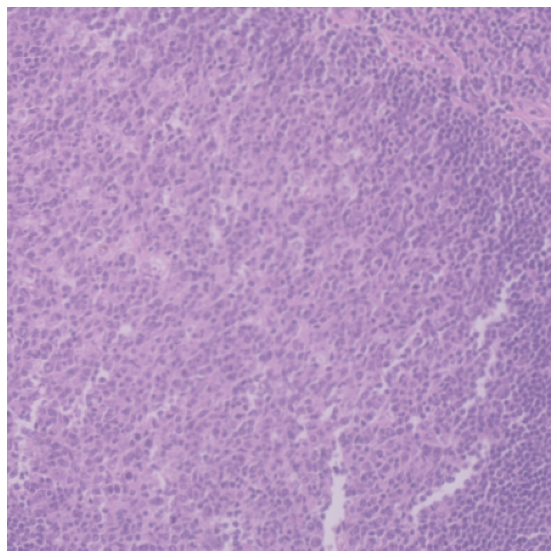

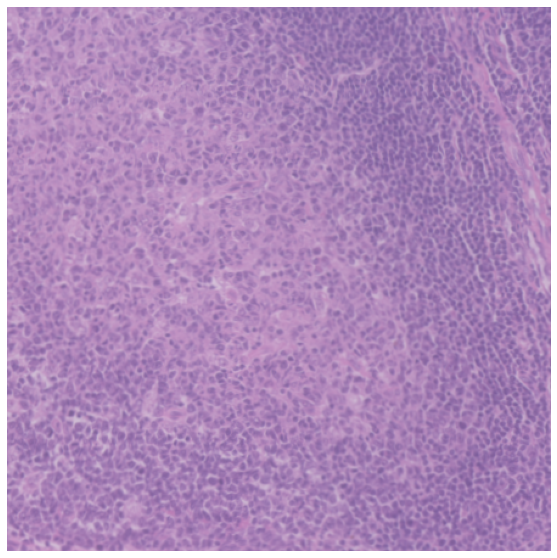

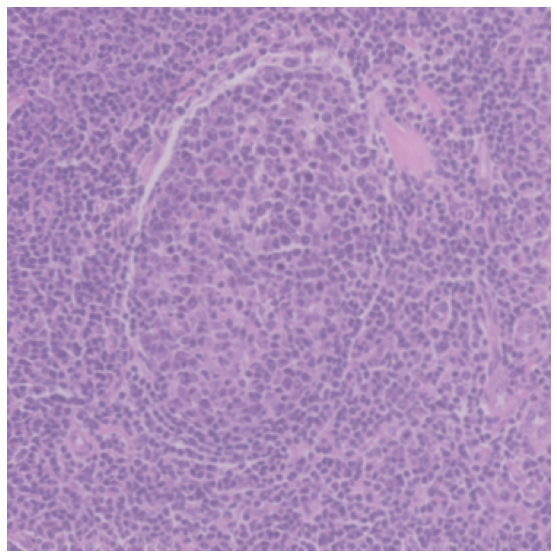

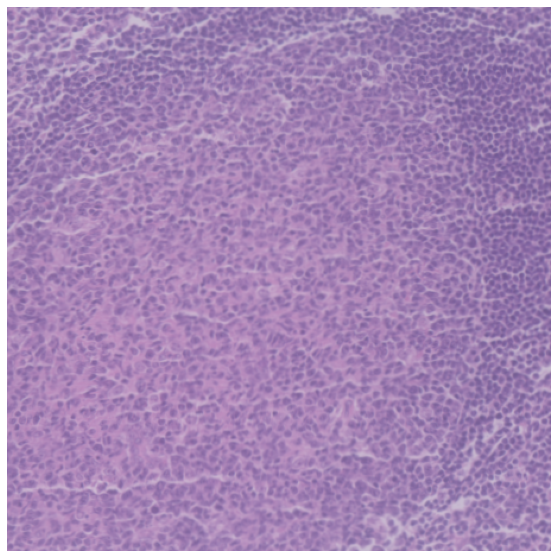

In [140]:
for img_cropped in imgs_cropped:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img_cropped)
    ax.axis('off')
    plt.show()